<img src="https://datascientest.fr/train/assets/logo_datascientest.png" style="height:150px"> 
<hr style="border-width:2px;border-color:##75DFC1">
<center> <h1> Projet COVID </h1> </center> <br>
<center> <h2> Premier prototype</h2> </center> <br>
<hr style="border-width:2px;border-color:##75DFC1">

Première implémentation d'un CNN sur les images
<hr style="border-width:2px;border-color:##75DFC1">

>CNN sur Keras

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

os.chdir('COVID-19 Radiography Database')

df = pd.read_csv('img_metadata.csv')

In [2]:
df.head()

,path,Class,height,width,channel,B&W,luminosite
0,COVID/COVID (934).png,covid,331.0,331.0,3.0,True,106.488376
1,COVID/COVID (296).png,covid,256.0,256.0,3.0,True,119.666504
2,COVID/COVID (74).png,covid,256.0,256.0,3.0,True,153.078995
3,COVID/COVID (261).png,covid,256.0,256.0,3.0,True,186.787781
4,COVID/COVID (978).png,covid,331.0,331.0,3.0,True,159.006818


In [4]:
print(df[['height', 'width']].value_counts())

height  width 
1024.0  1024.0    2686
331.0   331.0      573
256.0   256.0      558
891.0   1084.0      31
952.0   1184.0       9
992.0   1192.0       6
1047.0  1275.0       6
1053.0  1053.0       4
917.0   1116.0       4
852.0   1039.0       1
197.0   253.0        1
723.0   594.0        1
913.0   1102.0       1
875.0   1108.0       1
913.0   1108.0       1
928.0   1130.0       1
947.0   1192.0       1
160.0   187.0        1
dtype: int64


In [3]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import time, cv2
import seaborn as sns

import pandas as pd
from sklearn.model_selection import train_test_split

from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras import backend as K

In [5]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.02,
                                   zoom_range = 0.02,
                                   rotation_range=15,                   # le plus important
                                   width_shift_range=0.02,
                                   height_shift_range=0.02,
                                   brightness_range = [0.9, 1.1],       # avant ou après le rescale ?
                                   horizontal_flip=False,               # pas de flip pour des images médicales
                                   fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale = 1./255)

In [6]:
data = df[['path', 'Class']]
data['Class'] = data['Class'].replace({'covid' : 1, 'normal' : 0, 'pneumo' : 2})

data_train, data_test = train_test_split(data, test_size=0.2, random_state=123)

<ipython-input-6-097d295e3a2f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Class'] = data['Class'].replace({'covid' : 1, 'normal' : 0, 'pneumo' : 2})


In [7]:
data_train

,path,Class
2396,NORMAL/NORMAL (1192).png,0
1120,COVID/COVID (865).png,1
1840,NORMAL/NORMAL (316).png,0
1134,COVID/COVID (219).png,1
1268,NORMAL/NORMAL (350).png,0
...,...,...
1122,COVID/COVID (1147).png,1
1346,NORMAL/NORMAL (193).png,0
3454,Viral Pneumonia/Viral Pneumonia (1096).png,2
3437,Viral Pneumonia/Viral Pneumonia (468).png,2


In [8]:
batch_size = 32

data_train["Class"] = data_train["Class"].astype(str)
data_test["Class"] = data_test["Class"].astype(str)

training_set = train_datagen.flow_from_dataframe(dataframe=data_train,
                                                 directory="",
                                                 x_col = "path",
                                                 y_col = "Class",
                                                 target_size = (160, 160),   # plus petite dimension du dataset
                                                 batch_size = batch_size, 
                                                 color_mode='grayscale',
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_dataframe(dataframe=data_test,
                                            directory="",
                                            x_col = "path",
                                            y_col = "Class",
                                            target_size = (160, 160),
                                            batch_size = batch_size,
                                            color_mode='grayscale',
                                            class_mode = 'categorical')

Found 3108 validated image filenames belonging to 3 classes.
Found 778 validated image filenames belonging to 3 classes.


<ipython-input-8-6ae6e73eeca2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train["Class"] = data_train["Class"].astype(str)
<ipython-input-8-6ae6e73eeca2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test["Class"] = data_test["Class"].astype(str)


In [9]:
classifier = Sequential()
conv2d_5 = Conv2D(filters = 32, 
                  kernel_size = (3, 3), 
                  padding = 'valid', 
                  input_shape = (160, 160, 1), 
                  activation = 'relu')
max_pooling2d_5 = MaxPooling2D(pool_size = (2, 2))
conv2d_6 = Conv2D(filters = 32,                    
                  kernel_size = (3, 3),          
                  padding = 'valid',             
                  activation = 'relu')
max_pooling2d_6 = MaxPooling2D(pool_size = (2, 2))
flatten_3 = Flatten()
dense_5 = Dense(units = 128,
                activation = 'relu')
dense_6 = Dense(units = 3,
                activation = 'softmax')

classifier.add(conv2d_5)
classifier.add(max_pooling2d_5)
classifier.add(conv2d_6)
classifier.add(max_pooling2d_6)
classifier.add(Dropout(0.25))     # pour éviter le sur-apprentissage
classifier.add(flatten_3)
classifier.add(dense_5)
classifier.add(Dropout(0.2))           # pour éviter le sur-apprentissage
classifier.add(dense_6)

# Compilation
classifier.compile(loss = 'categorical_crossentropy', 
                   optimizer = 'adam', 
                   metrics = ['accuracy'])

classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 158, 158, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 79, 79, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 77, 77, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 38, 38, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 46208)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               5

In [10]:
# Entraînement
history = classifier.fit(training_set, 
                                   epochs = 30,
                                   workers = -1,
                                   steps_per_epoch = len(data_train)//batch_size,
                                   validation_data = test_set,
                                   validation_steps = len(data_test)//batch_size)

Epoch 1/30
97/97 [==============================] - 55s 562ms/step - loss: 0.9359 - accuracy: 0.6061 - val_loss: 0.2630 - val_accuracy: 0.8984
Epoch 2/30
97/97 [==============================] - 49s 501ms/step - loss: 0.3258 - accuracy: 0.8756 - val_loss: 0.3160 - val_accuracy: 0.8880
Epoch 3/30
97/97 [==============================] - 49s 506ms/step - loss: 0.2663 - accuracy: 0.9040 - val_loss: 0.2560 - val_accuracy: 0.9193
Epoch 4/30
97/97 [==============================] - 49s 509ms/step - loss: 0.2324 - accuracy: 0.9141 - val_loss: 0.2413 - val_accuracy: 0.9323
Epoch 5/30
97/97 [==============================] - 49s 506ms/step - loss: 0.1820 - accuracy: 0.9385 - val_loss: 0.1680 - val_accuracy: 0.9479
Epoch 6/30
97/97 [==============================] - 47s 490ms/step - loss: 0.2041 - accuracy: 0.9290 - val_loss: 0.1862 - val_accuracy: 0.9427
Epoch 7/30
97/97 [==============================] - 48s 495ms/step - loss: 0.1681 - accuracy: 0.9365 - val_loss: 0.1582 - val_accuracy: 0.9492

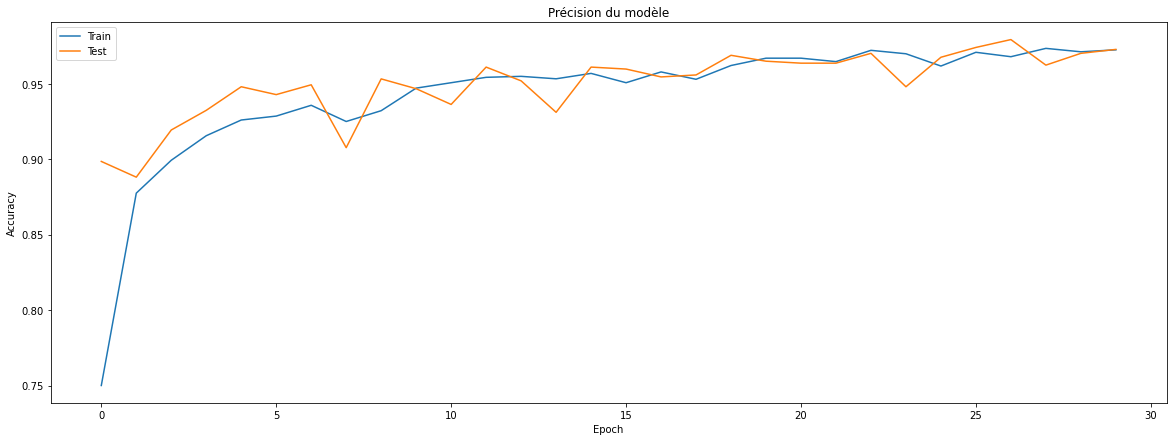

In [11]:
plt.figure(figsize = (20,7))
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Précision du modèle")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc = "upper left")
plt.show()

In [12]:
# enregistrement du modèle 

classifier.save('premier_prototype.h5')